Поставлена задача анализа и обработки датасета, содержащего информацию об оттоке клиентов из телекома. Необходимо разработать модель, способную с высокой точностью прогнозировать отток клиентов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Нужно построить модель, предсказывающую отток, оценить качество этой модели и гипотетические перспективы использования этой модели в реальном бизнес-процессе. Для начала рассмотрим имеющийся датасет

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/sonofastronaut/test_mts/main/telco-customer-churn.csv"
)

df.head()


,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,...,216,144,No,No,0.48,3122,624,0,2015,1


In [3]:
# пропуски
missing = df.isna().mean().sort_values(ascending=False)
print("\nДоля пропусков по колонкам:\n", missing)

# дубликаты
duplicates_count = df.duplicated().sum()
print("\nКоличество дубликатов:", duplicates_count)



Доля пропусков по колонкам:
 age                                     0.0
annualincome                            0.0
calldroprate                            0.0
callfailurerate                         0.0
callingnum                              0.0
customerid                              0.0
customersuspended                       0.0
education                               0.0
gender                                  0.0
homeowner                               0.0
maritalstatus                           0.0
monthlybilledamount                     0.0
noadditionallines                       0.0
numberofcomplaints                      0.0
numberofmonthunpaid                     0.0
numdayscontractequipmentplanexpiring    0.0
occupation                              0.0
penaltytoswitch                         0.0
state                                   0.0
totalminsusedinlastmonth                0.0
unpaidbalance                           0.0
usesinternetservice                     0.0
us

Откроем и проанализируем датасет. Размер сета 20468 строк на 29 столбцов, среди столбцов есть категориальные значения, которые необходимо предобработать. Так же отдельно отмечу, что в датасете полностью отсутствуют пропуски, дубликаты или ячейки со значением NULL, что исключает необходимость в обработке числовых значений. Однако, при рассмотрении датасета видно, что в нем есть столбец noadditionallines, в котором все значения равны \N, что говорит о неинформативности данного столбца, покажу ниже

In [4]:
# \N-значения
null_counts = {}
for column in df.columns:
    # Считаем точные совпадения с '\N'
    count = (df[column] == '\\N').sum()
    if count > 0:
        null_counts[column] = count

# Вывод результатов
print(f"Всего столбцов: {len(df.columns)}")
print(f"Столбцов с значением '\\N': {len(null_counts)}")
print("\nРаспределение значений '\\N' по столбцам:")
if null_counts:
    for col, count in null_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {col}: {count} строк ({percentage:.2f}%)")
else:
    print("  Значения '\\N' не найдены")

Всего столбцов: 29
Столбцов с значением '\N': 1

Распределение значений '\N' по столбцам:
  noadditionallines: 20468 строк (100.00%)


Так же перед кодированием категориальных столбцов, я рассмотрю количество уникальных значений в каждой колонке

In [5]:
# Вывод количества уникальных значений в каждой колонке
cat_cols = df.select_dtypes(include=['object']).columns

print("Уникальные значения в категориальных столбцах:")
print("=" * 50)

for col in cat_cols:
    unique_count = df[col].nunique()
    print(f"\n{col}:")
    print(f"  Уникальных значений: {unique_count}")

Уникальные значения в категориальных столбцах:

customersuspended:
  Уникальных значений: 2

education:
  Уникальных значений: 4

gender:
  Уникальных значений: 2

homeowner:
  Уникальных значений: 2

maritalstatus:
  Уникальных значений: 2

noadditionallines:
  Уникальных значений: 1

occupation:
  Уникальных значений: 3

state:
  Уникальных значений: 50

usesinternetservice:
  Уникальных значений: 2

usesvoiceservice:
  Уникальных значений: 2


Внимание стоит обратить на столбец state, в котором есть 50 уникальных значений, что при OHE даст нам 50 новых столбцов, тогда как в самом датасете их 29. Решение об удалении этого столбца я приму после построения матрицы корреляций

Далее рассмотрим, как распределена целевая переменная

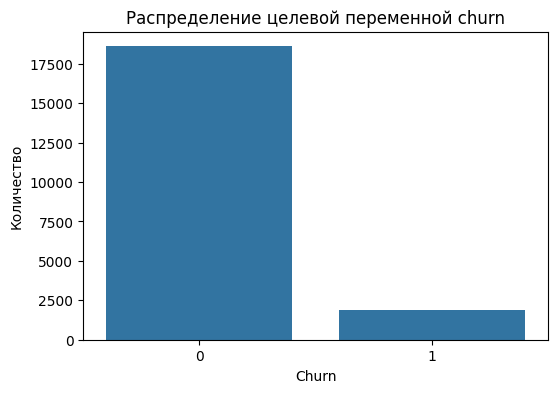


Доли классов:
churn
0    0.90898
1    0.09102
Name: proportion, dtype: float64


In [6]:
# ============================================================
# 2. EDA: распределение целевой переменной
# ============================================================
plt.figure(figsize=(6, 4))
sns.countplot(x="churn", data=df)
plt.title("Распределение целевой переменной churn")
plt.xlabel("Churn")
plt.ylabel("Количество")
plt.show()

print("\nДоли классов:")
print(df["churn"].value_counts(normalize=True))

В распределении целевой переменной виден явный дисбаланс, но стоит отметить, что в телекоме такое распределение можно назвать ожидаемым, потому что люди довольно редко меняют оператора связи. При дальнейшей обработке данного датасета я должен учесть этот дисбаланс

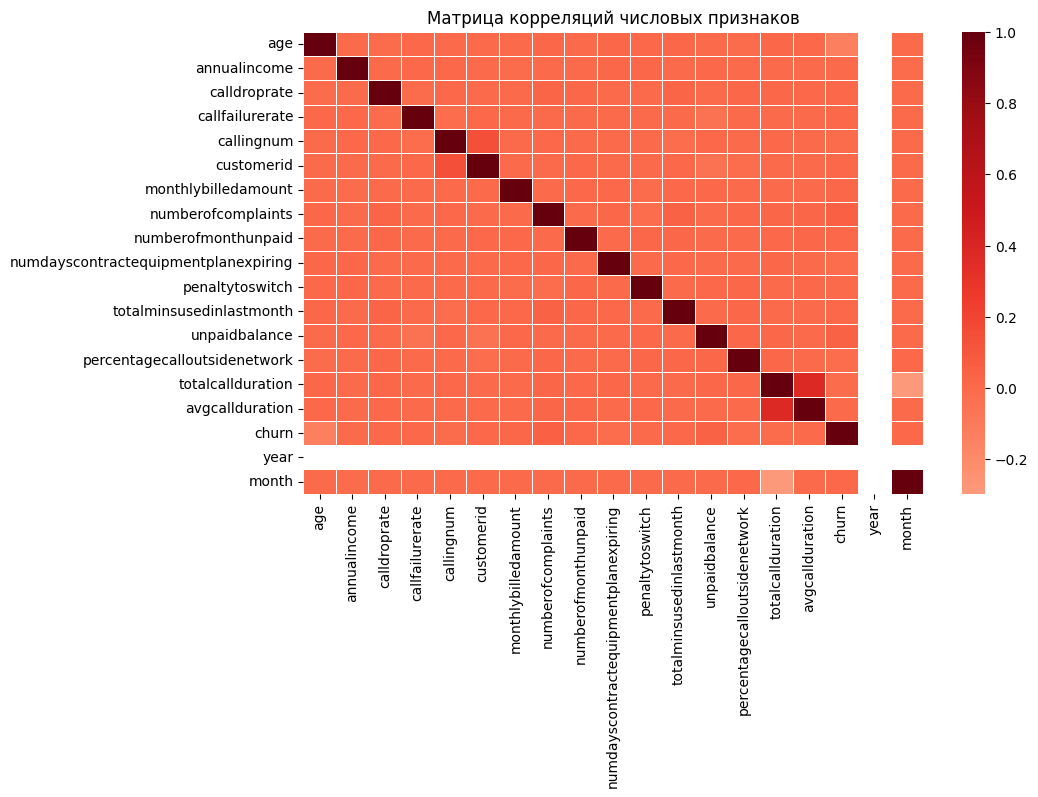

In [7]:
# ============================================================
# 3. Корреляции числовых признаков
# ============================================================
df_corr = df.copy()
df_corr["churn"] = df_corr["churn"].astype(int)

num_cols_corr = df_corr.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 6))
sns.heatmap(
    num_cols_corr.corr(),
    cmap="Reds",
    center=0,
    linewidths=0.5
)
plt.title("Матрица корреляций числовых признаков")
plt.show()

Проанализируем матрицу корреляций. Из неё становится очевидно, что сильных линейных связей между фичами и целевой переменной нет. Но тем не менее, мы можем отбросить:
 - callingnum - номер телефона, уникальный идентификатор без предсказательной силы
  - noadditionallines - параметр, на 100% состоящий из \N, который так же не несет никакой информации.
  
  
  Так же хочу отметить слабую корреляцию между state и целевой переменной. В действительности, для крупных провайдеров география не сильно влияет отток, поэтому фичу state тоже можно исключить.
  
  Удалим перечисленные фичи

In [8]:
df = df.drop(columns=['callingnum', 'noadditionallines', 'state'])
df.shape

(20468, 26)

Далее произведем подготовку данных, разобьем на трейн и тест


In [9]:
# ============================================================
# 4. Подготовка данных
# ============================================================
X = df.drop(columns=["churn"])
y = df["churn"].astype(int)

# Identify features for the ColumnTransformer
categorical_features_for_pipeline = X.select_dtypes(include=['object']).columns
numerical_features_for_pipeline = X.select_dtypes(include=[np.number]).columns

# Remove 'customerid' from numerical features as it's an identifier and not a predictive feature
if 'customerid' in numerical_features_for_pipeline:
    numerical_features_for_pipeline = numerical_features_for_pipeline.drop('customerid')

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

Закодируем категориальные колонки с помощью OHE

In [10]:
# Определяем категориальные колонки (кроме ID и целевой переменной)
exclude_from_encoding = ['customerid', 'churn']  # не кодируем
cat_cols = [col for col in df.select_dtypes(include=['object']).columns
            if col not in exclude_from_encoding]

print(f"Категориальные колонки для кодирования ({len(cat_cols)}):")
for col in cat_cols:
    print(f"  - {col}: {df[col].nunique()} уникальных значений")

# OneHot кодирование
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = ohe.fit_transform(df[cat_cols])

# Создаем DataFrame с закодированными колонками
encoded_cols = ohe.get_feature_names_out(cat_cols)
df_cat_encoded = pd.DataFrame(cat_encoded, columns=encoded_cols, index=df.index)

# Объединяем с числовыми данными
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df_final = pd.concat([
    df[num_cols + exclude_from_encoding],  # числовые + ID + целевая
    df_cat_encoded                         # закодированные категориальные
], axis=1)

print(f"\nИтоговый размер: {df_final.shape}")

Категориальные колонки для кодирования (8):
  - customersuspended: 2 уникальных значений
  - education: 4 уникальных значений
  - gender: 2 уникальных значений
  - homeowner: 2 уникальных значений
  - maritalstatus: 2 уникальных значений
  - occupation: 3 уникальных значений
  - usesinternetservice: 2 уникальных значений
  - usesvoiceservice: 2 уникальных значений

Итоговый размер: (20468, 39)


После OHE получили вполне нормальное число колонок, теперь обучим модели dummy, логистическую регрессию, рандом форест и градиентный бустинг и посмотрим, как они справятся с обработанным датасетом

In [11]:
# ============================================================
# 6. Модели
# ============================================================
models = {
    "dummy": DummyClassifier(strategy="most_frequent"),
    "decision_tree": DecisionTreeClassifier(max_depth=6),
    "random_forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "gradient_boosting": GradientBoostingClassifier(random_state=42)
}


In [12]:
# ============================================================
# 7. Обучение и оценка моделей
# ============================================================

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features_for_pipeline),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_for_pipeline)
    ],
    remainder='drop' # Drop any other columns not explicitly specified
)

roc_auc_scores = {}
roc_curves = {}
pr_auc_scores = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor), # Add the preprocessor as the first step
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, probs)
    roc_auc_scores[name] = roc_auc

    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_curves[name] = (fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc_scores[name] = average_precision_score(y_test, probs)

    print("=" * 60)
    print(name.upper())
    print("=" * 60)
    print(f"Accuracy:  {accuracy_score(y_test, preds):.4f}")
    print(f"Precision: {precision_score(y_test, preds, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_test, preds, zero_division=0):.4f}")
    print(f"F1-score:  {f1_score(y_test, preds, zero_division=0):.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print("\nConfusion matrix:\n", confusion_matrix(y_test, preds))
    print("\nClassification report:\n", classification_report(y_test, preds, zero_division=0))


DUMMY
Accuracy:  0.9089
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.5000

Confusion matrix:
 [[3721    0]
 [ 373    0]]

Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      3721
           1       0.00      0.00      0.00       373

    accuracy                           0.91      4094
   macro avg       0.45      0.50      0.48      4094
weighted avg       0.83      0.91      0.87      4094

DECISION_TREE
Accuracy:  0.9082
Precision: 0.4118
Recall:    0.0188
F1-score:  0.0359
ROC-AUC:   0.7218

Confusion matrix:
 [[3711   10]
 [ 366    7]]

Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      3721
           1       0.41      0.02      0.04       373

    accuracy                           0.91      4094
   macro avg       0.66      0.51      0.49      4094
weighted avg       0.86      0.91      0.87      4094

RA

Модели обучены. По отчетам уже можем сделать вывод о том, что лучше всего в этом наборе моделей отработал рандом форест, показав самый лучший f1 и recall. Неидеально, но лучше, чем остальные модели. Построим ROC-AUC кривые для обученных моделей.

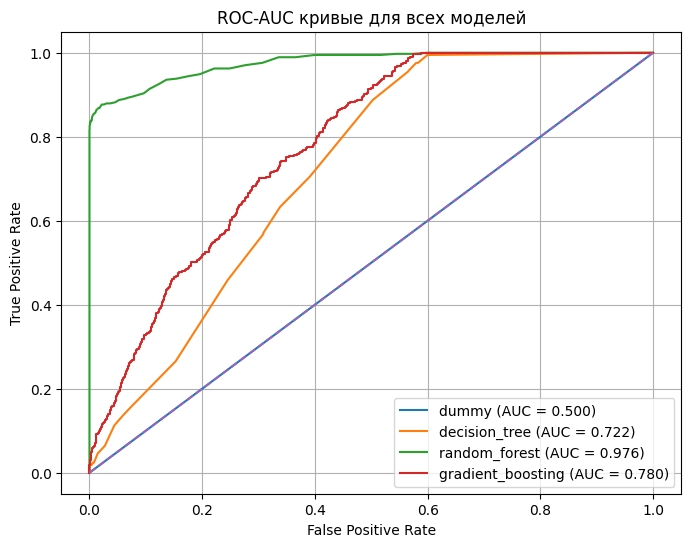

In [13]:

# ============================================================
# 8. ROC-AUC кривые
# ============================================================
plt.figure(figsize=(8, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_scores[name]:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC кривые для всех моделей")
plt.legend(loc="lower right")
plt.grid()


Графики ROC-AUC уже наглядно показывают нам, что лучше всего в этом наборе моделей отработал именно рандом форест.

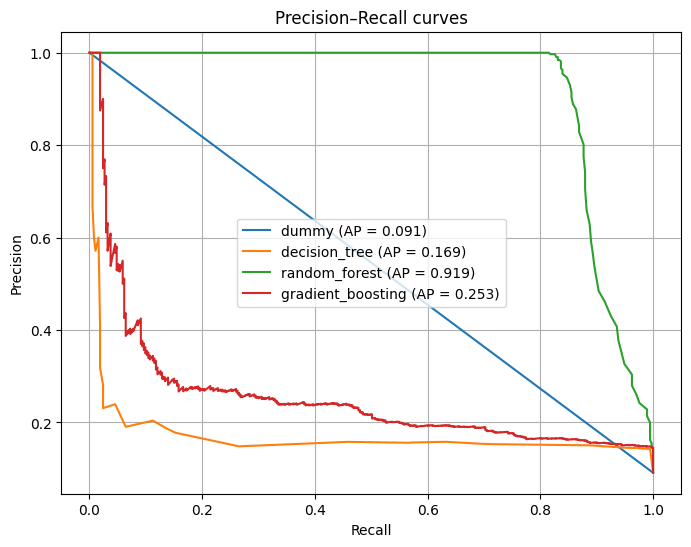

In [19]:
plt.figure(figsize=(8, 6))
for name, model in models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    probs = pipe.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)

    plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves")
plt.legend()
plt.grid()
plt.show()


На графике precision-recall так же видно, что лучшее соотношение показывает именно рандом форест, тогда как остальные модели практически не определяют отток.

Какой вывод можно сделать из проделанного исследования: из обученных моделей мы получили то, что без работы с гиперпараметрами и балансировкой классов лучше всего с предсказанием оттока справляется рандом форест. В дальнейшем при внедрении этой модели в бизнес-процессы можно увеличить процент предсказываемого оттока. Так же хочу отметить, что можно дополнительно поработать с бустингом, например, использовать LightGBM или XGBoost, их результаты явно можно приблизить к результатам рандом фореста